In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [6]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)


In [7]:
import os
import pandas as pd

EOSINOPHIL_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL'
]
LYMPHOCYTE_dir = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE'
]
MONOCYTE_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE'
]
NEUTROPHIL_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL'
]

filepaths = []
labels = []

dict_lists = [EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())


                                           filepaths      labels
0  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
1  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
2  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
3  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
4  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


In [8]:
print(bloodCell_df)

                                              filepaths      labels
0     /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
1     /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
2     /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
3     /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
4     /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
...                                                 ...         ...
9952  /kaggle/input/blood-cells/dataset2-master/data...  NEUTROPHIL
9953  /kaggle/input/blood-cells/dataset2-master/data...  NEUTROPHIL
9954  /kaggle/input/blood-cells/dataset2-master/data...  NEUTROPHIL
9955  /kaggle/input/blood-cells/dataset2-master/data...  NEUTROPHIL
9956  /kaggle/input/blood-cells/dataset2-master/data...  NEUTROPHIL

[9957 rows x 2 columns]


In [10]:
import cv2

for index, row in bloodCell_df.iterrows():
    image_path = row['filepaths']
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    print(f"Image {index+1}: Size {width}x{height}")

Image 1: Size 320x240
Image 2: Size 320x240
Image 3: Size 320x240
Image 4: Size 320x240
Image 5: Size 320x240
Image 6: Size 320x240
Image 7: Size 320x240
Image 8: Size 320x240
Image 9: Size 320x240
Image 10: Size 320x240
Image 11: Size 320x240
Image 12: Size 320x240
Image 13: Size 320x240
Image 14: Size 320x240
Image 15: Size 320x240
Image 16: Size 320x240
Image 17: Size 320x240
Image 18: Size 320x240
Image 19: Size 320x240
Image 20: Size 320x240
Image 21: Size 320x240
Image 22: Size 320x240
Image 23: Size 320x240
Image 24: Size 320x240
Image 25: Size 320x240
Image 26: Size 320x240
Image 27: Size 320x240
Image 28: Size 320x240
Image 29: Size 320x240
Image 30: Size 320x240
Image 31: Size 320x240
Image 32: Size 320x240
Image 33: Size 320x240
Image 34: Size 320x240
Image 35: Size 320x240
Image 36: Size 320x240
Image 37: Size 320x240
Image 38: Size 320x240
Image 39: Size 320x240
Image 40: Size 320x240
Image 41: Size 320x240
Image 42: Size 320x240
Image 43: Size 320x240
Image 44: Size 320x2

In [11]:
from collections import Counter

image_sizes = Counter()

for index, row in bloodCell_df.iterrows():
    image_path = row['filepaths']
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes[(width, height)] += 1

print("List of all image sizes:")
for size, count in image_sizes.items():
    print(f"Size {size[0]}x{size[1]}: {count} images")


List of all image sizes:
Size 320x240: 9957 images


In [12]:
bloodCell_df.shape

(9957, 2)

In [13]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [14]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


In [15]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [16]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


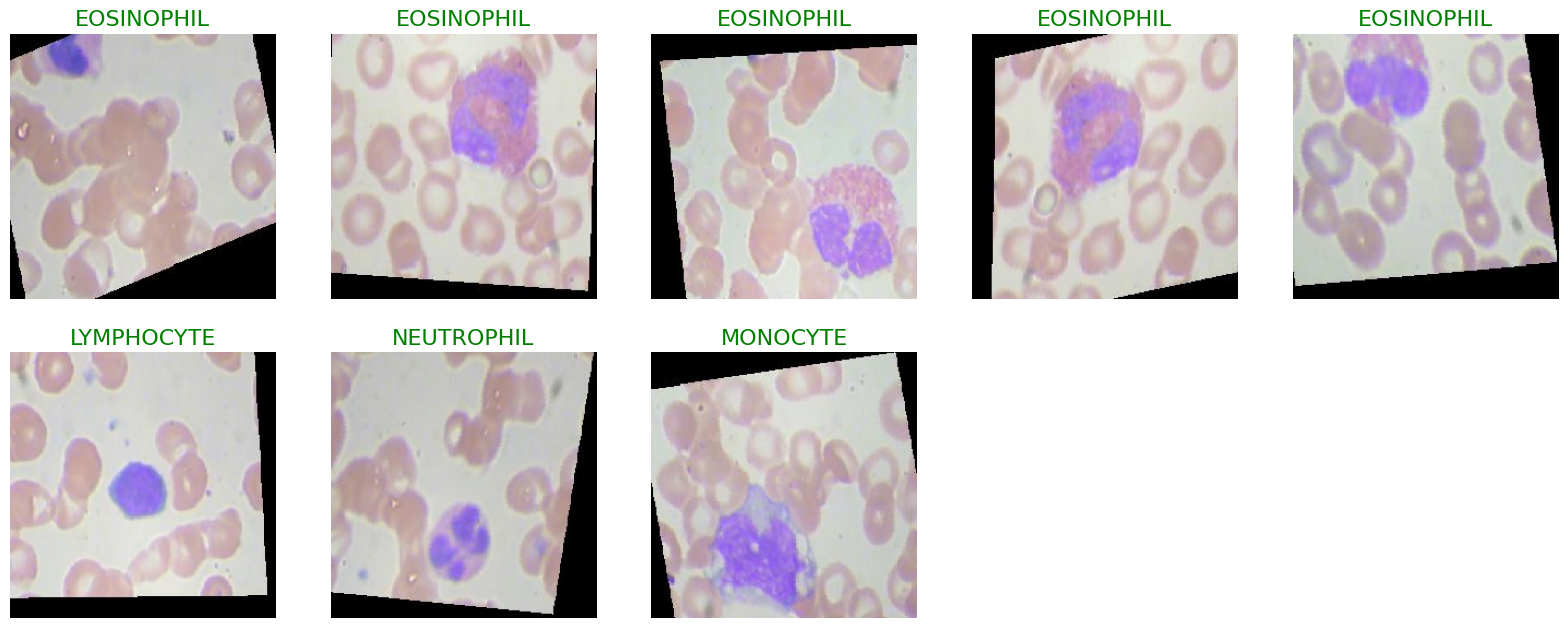

In [17]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [18]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [26]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

# Load the MobileNetV3Large model
mobilenet_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Create model3 as a Sequential model
model3 = Sequential()

# Add MobileNetV3 to model3
model3.add(mobilenet_model)

# Add new layers
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

# Compile the model
model3.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

# Print model summary
model3.summary()


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 8, 8, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,742,580 (151.61 MB)

 Trainable params: 39,730,468 (151.56 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [24]:
!pip install livelossplot

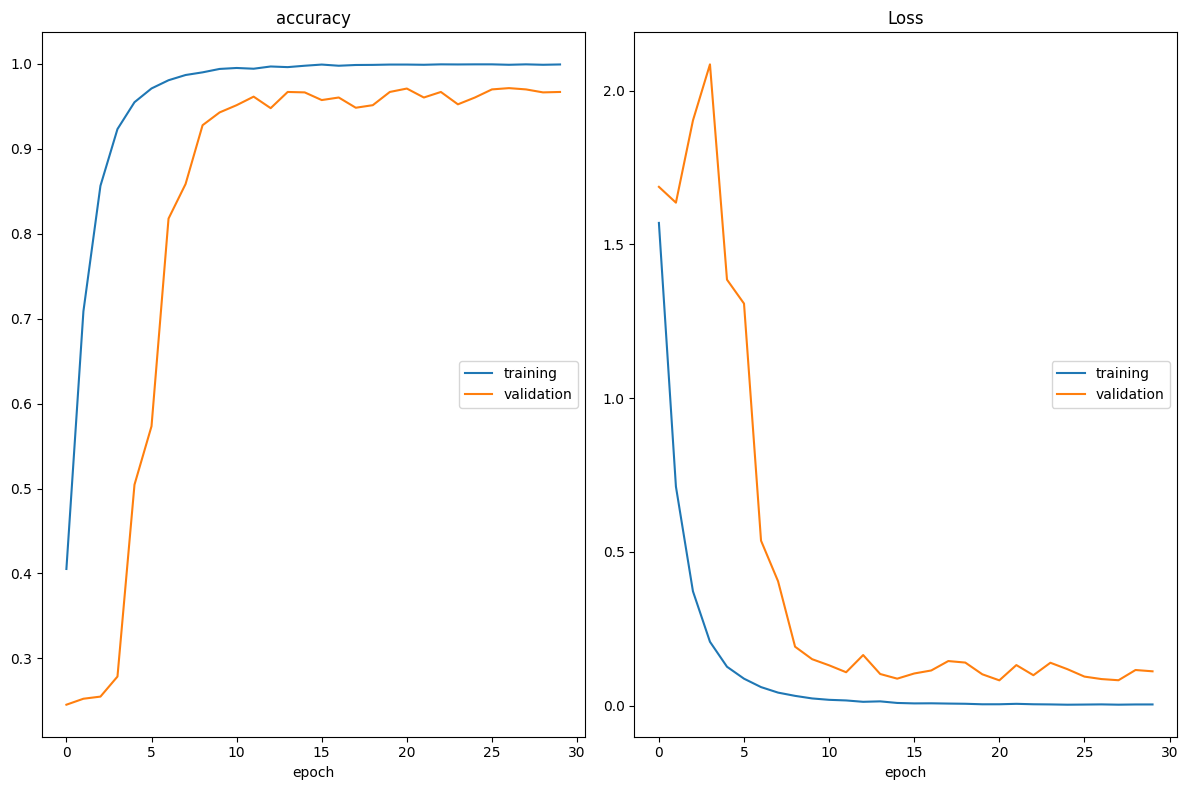

accuracy
	training         	 (min:    0.405, max:    0.999, cur:    0.999)
	validation       	 (min:    0.245, max:    0.971, cur:    0.967)
Loss
	training         	 (min:    0.003, max:    1.570, cur:    0.004)
	validation       	 (min:    0.082, max:    2.085, cur:    0.112)
996/996 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9669 - val_loss: 0.1117
Training time:  0:15:35.907553


In [27]:
from datetime import datetime
from livelossplot import PlotLossesKeras
# Fit the model
start = datetime.now()
history = model3.fit(train, epochs=30, validation_data=val, verbose=1, callbacks=[PlotLossesKeras()])
stop = datetime.now() - start
print("Training time: ", stop)

In [28]:
model3.evaluate(test, verbose=1)

374/374 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9671 - loss: 0.1098


[0.07559467852115631, 0.9772422909736633]

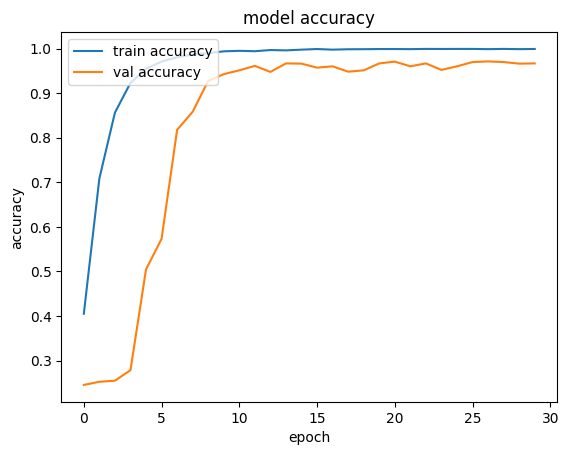

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

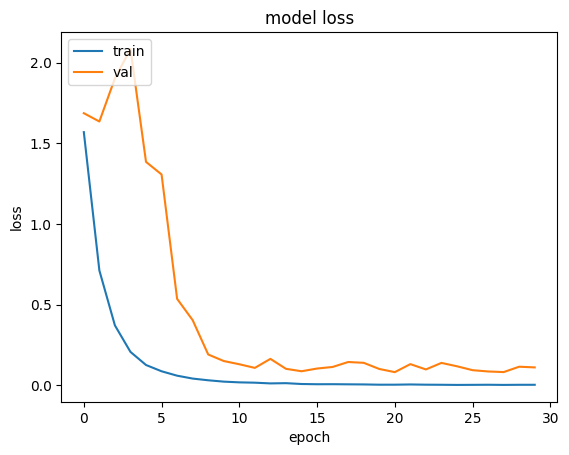

In [30]:
plt.plot(history.history['loss'], label='train loss' )
plt.plot(history.history['val_loss'], label='val loss' )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
pred = model3.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Assuming y_test and pred2 are both numpy arrays or lists of labels
print(classification_report(y_test, pred2))

# Compute individual metrics
accuracy = accuracy_score(y_test, pred2)
precision = precision_score(y_test, pred2, average='weighted')
recall = recall_score(y_test, pred2, average='weighted')
f1 = f1_score(y_test, pred2, average='weighted')

# Print results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.96      0.96       781
  LYMPHOCYTE       1.00      1.00      1.00       764
    MONOCYTE       1.00      1.00      1.00       729
  NEUTROPHIL       0.95      0.96      0.95       714

    accuracy                           0.98      2988
   macro avg       0.98      0.98      0.98      2988
weighted avg       0.98      0.98      0.98      2988

Accuracy: 97.72%
Precision: 0.9772
Recall: 0.9772
F1 Score: 0.9772


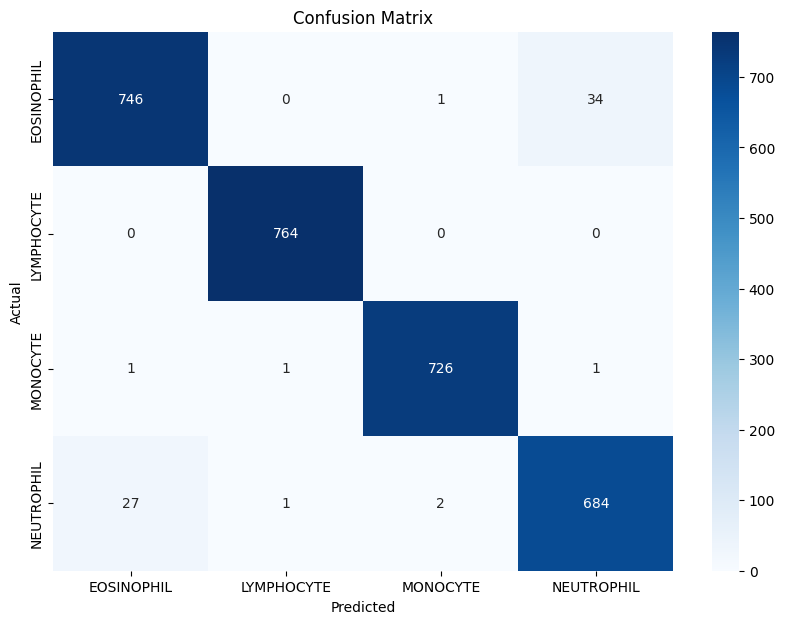

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

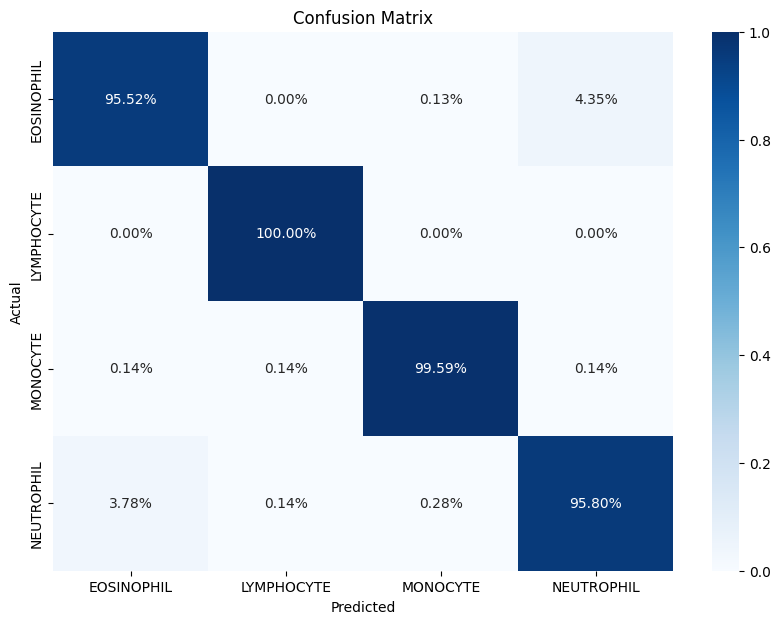

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()
